In [1]:
# Core
import pandas as pd
import numpy as np
import os
import random
import re
import tqdm
import kaggle

# Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import preprocessor as p

# Gensim LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Lemmatization, Stop Words
import spacy # python -m spacy download en_core_web_sm

# Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dcmabry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Download dataset
# Authentication https://www.kaggle.com/
# In order to use the Kaggle’s public API, you must first authenticate using an API token.
# From the site header, click on your user profile picture, then on “My Account” from the dropdown menu.
#v This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:
# To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.
# Save the token in your home directory, for Linux users ~/.kaggle/kaggle.json or C:\Users<Windows-username>.kaggle\kaggle.json on Windows
kaggle.api.authenticate()
kaggle.api.dataset_download_files('rapiddev/us-presidential-election-tweets-2020', path='.', unzip=True)

In [3]:
# Dataframe
df = pd.read_csv("tweets.csv")

In [4]:
# Format datetime types
df["created_at"] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
df["processed_dttm"] = pd.to_datetime(df['processed_dttm'], format='%Y-%m-%d %H:%M:%S.%f')

In [5]:
# Load stop words and spacy nlp tokenizer
stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

In [6]:
# Clean tweets
def preprocess_tweet(text):
    return p.clean(text)

# Get hashtags
def preprocess_hashtags(text):
    hashtags = p.parse(text).hashtags
    return [hashtag.match for hashtag in hashtags] if hashtags else []

In [7]:
# Preprocessing
df["hashtag"] = df["tweet"].apply(lambda x: preprocess_hashtags(x)) # Get hashtags for future analysis
df["tweet"] = df["tweet"].apply(lambda x: preprocess_tweet(x)) # Twitter preprocessing https://pypi.org/project/tweet-preprocessor/
data = df["tweet"].values.tolist() # Convert to list

In [8]:
# Tokenization, remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
# Build data words list
data_words = list(sent_to_words(data))

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'PROPN']) # Keep only nouns, adj, verbs, and pronouns for topics

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=42,
                                       chunksize=1000,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [ ]:
vis

In [ ]:
# World Cloud Plots
def create_word_cloud(topics, nrows, ncols, color_theme, fig_name):
    colors = [color for name, color in color_theme]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab20',
                      color_func=lambda *args, **kwargs: colors[i],
                      prefer_horizontal=1.0)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=500)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
        else:
            ax.axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

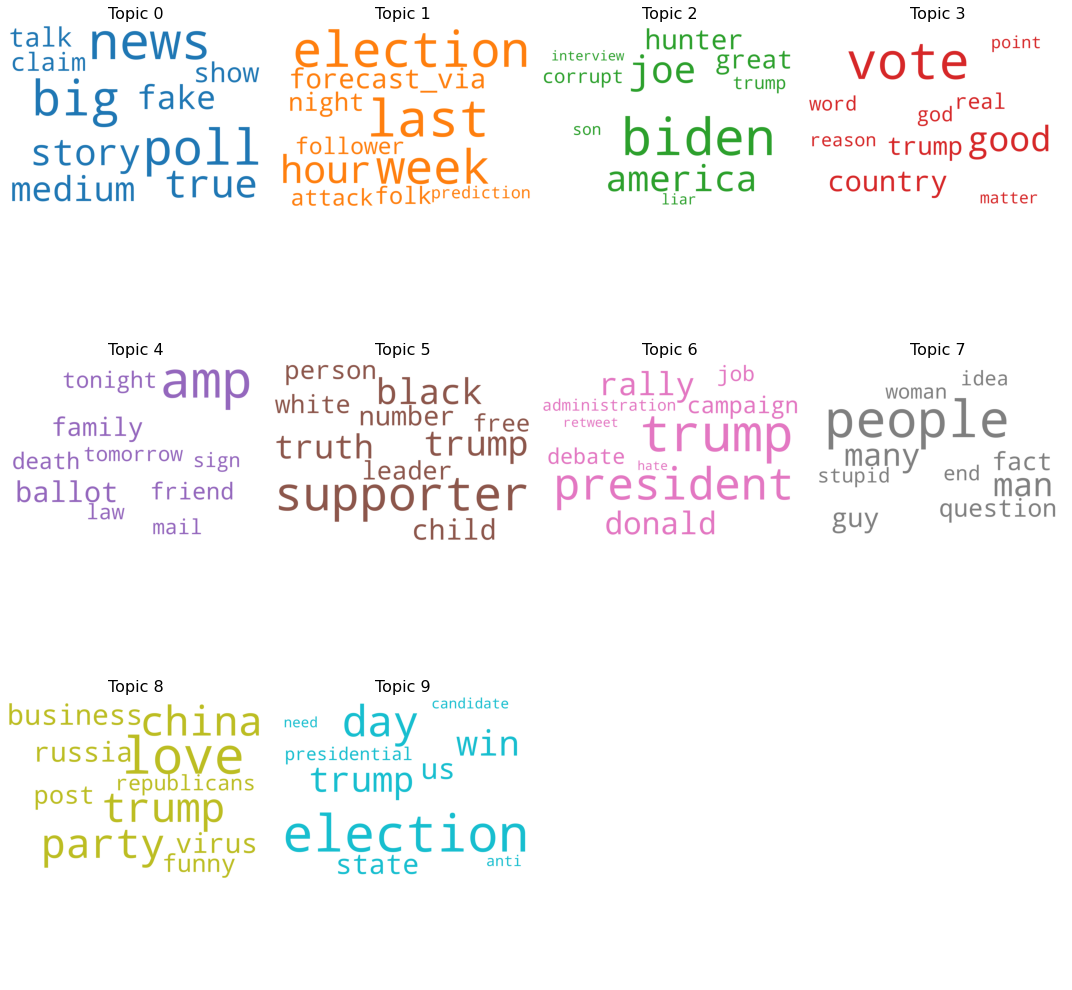

In [29]:
topics = lda_model.show_topics(formatted=False, num_topics=10) # Get top 10 topics
create_word_cloud(topics, 3, 4, mcolors.TABLEAU_COLORS.items(), 'word_cloud.png')

In [21]:
# Compute best k value for number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, \
                                                        corpus=corpus, \
                                                        texts=data_lemmatized, \
                                                        start=2, \
                                                        limit=40, \
                                                        step=5)

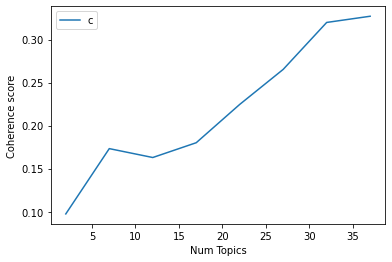

In [23]:
# Best k value
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Build LDA model
optimal_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=30,
                                       random_state=42,
                                       chunksize=1000,
                                       passes=10,
                                       per_word_topics=True)

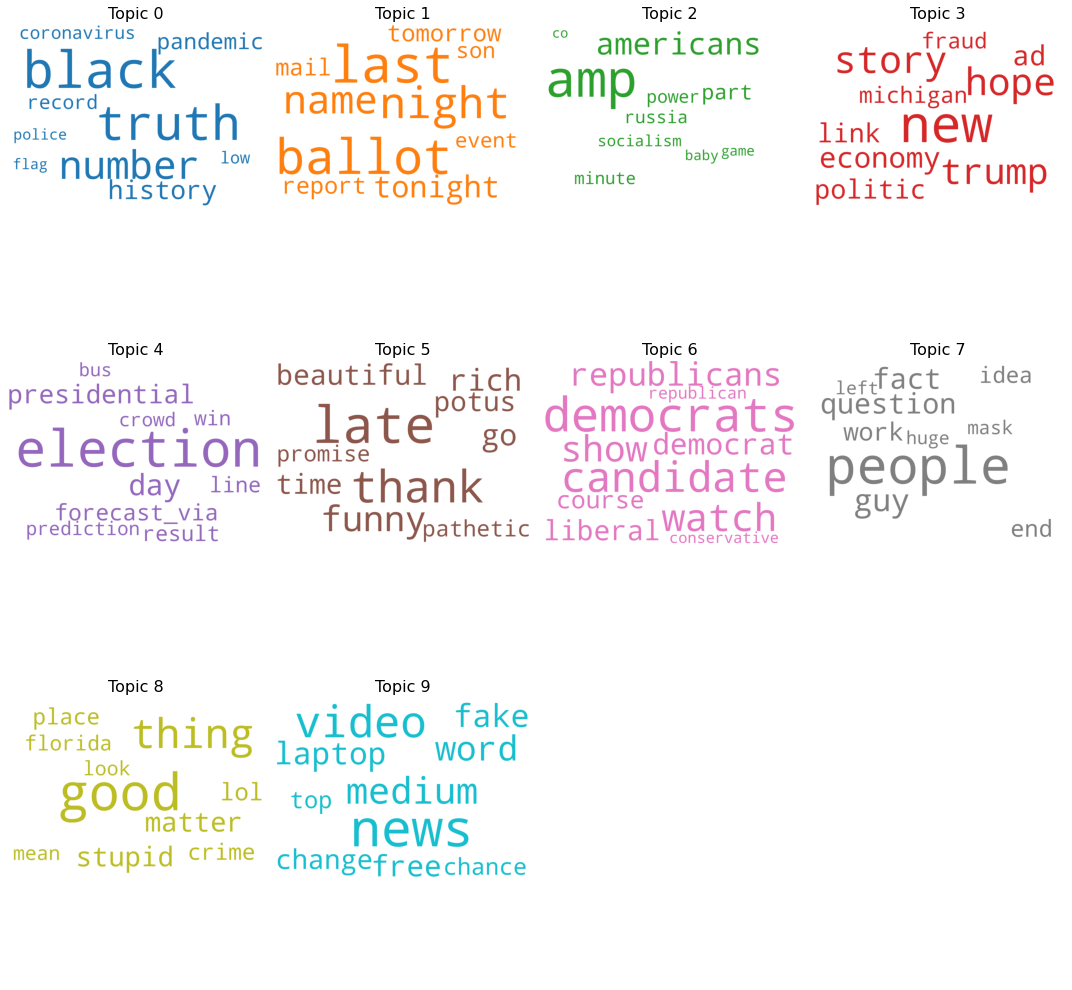

In [25]:
opt_topics = optimal_model.show_topics(formatted=False, num_topics=10) # Get top 10 topics
create_word_cloud(opt_topics, 3, 4, mcolors.TABLEAU_COLORS.items(), 'word_cloud_opt.png')

In [26]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_opt = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_opt = coherence_model_opt.get_coherence()
print('\nCoherence Score: ', coherence_lda_opt)


Perplexity:  -12.223753648136581

Coherence Score:  0.28899761347006386


In [27]:
pyLDAvis.enable_notebook()
vis_opt = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)

In [28]:
vis_opt

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.280856  0.069812       1        1  6.146356
26     0.005739  0.070760       2        1  5.133071
9      0.061745  0.009079       3        1  4.029651
13     0.079364  0.070440       4        1  3.891042
4      0.064630  0.017866       5        1  3.845320
29    -0.259357  0.024042       6        1  3.796200
19     0.021351  0.081547       7        1  3.763367
27    -0.035065 -0.307697       8        1  3.667237
22     0.037090 -0.257468       9        1  3.524525
28     0.078616  0.031732      10        1  3.475942
1      0.018956 -0.115539      11        1  3.435939
24     0.013036  0.032910      12        1  3.361709
0     -0.229058 -0.055769      13        1  3.305932
7      0.062358  0.044640      14        1  3.281261
3      0.046886 -0.002046      15        1  3.189532
17     0.002367  0.001599      16        1  3.120258
14     0.068957 -0.026953      17        1  3.038941
8      0.047242 -0.091830      18        1  3.018149
23    -0.190156  0.085067      19        1  3.006275
6     -0.091677  0.037011      20        1  2.985240
21     0.044677  0.038024      21        1  2.893397
18     0.036119  0.014346      22        1  2.830340
16     0.069213  0.082299      23        1  2.824629
11     0.065686  0.029706      24        1  2.802338
10     0.065046  0.041874      25        1  2.715662
20    -0.037252 -0.081466      26        1  2.616729
12     0.058933 -0.011147      27        1  2.605562
25     0.059501  0.043859      28        1  2.598951
5      0.058548  0.057350      29        1  2.557533
2      0.057361  0.065951      30        1  2.538911, topic_info=          Term          Freq         Total Category  logprob  loglift
24       biden  40256.000000  40256.000000  Default  30.0000  30.0000
29         amp  35979.000000  35979.000000  Default  29.0000  29.0000
16        vote  32326.000000  32326.000000  Default  28.0000  28.0000
15       trump  57507.000000  57507.000000  Default  27.0000  27.0000
26    election  25194.000000  25194.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
4879   program    346.439273    347.545784  Topic30  -5.1239   3.6702
598      voice   1726.134814   1941.833958  Topic30  -3.5180   3.5557
124     enough   1779.752070   2387.861968  Topic30  -3.4874   3.3795
6338   brother    623.574913    900.567565  Topic30  -4.5362   3.3059
47      bidens    831.763871   1797.616064  Topic30  -4.2481   2.9028

[1186 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2794     12  0.997916      able
408      16  0.996780  absolute
679       4  0.997675     abuse
216      30  0.998941   account
1575     20  0.991798    action
...     ...       ...       ...
348      12  0.852416   youtube
348      13  0.001733   youtube
348      22  0.143802   youtube
2001     26  0.998514       yrs
630       1  0.995990       yup

[2317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 27, 10, 14, 5, 30, 20, 28, 23, 29, 2, 25, 1, 8, 4, 18, 15, 9, 24, 7, 22, 19, 17, 12, 11, 21, 13, 26, 6, 3])